**Library Imports and Initial Setup**

In [ ]:
#Import necessary libraries
#Suppress the output
%%capture
!pip install fasttext
!pip install -U keras-tuner
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from google.colab import drive
import fasttext.util
import numpy as np
import keras_tuner as kt
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import warnings
warnings.filterwarnings('ignore')

**Preprocessing - Data Extraction**

We will be using the files from the previous assignment from the Venice Italian Treebank. The 'SYM' and 'PART' tags will be ignored as the subsets do not include them.

In [ ]:
def read_conllu(file_path):
    # Initialize an empty DataFrame with specified columns
    df = pd.DataFrame(columns=['Sentence', 'POS_Tags'])
    Pos_Tags = ''
    sentence = ''
    rows = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line == '':
                if sentence != '':
                    sentence = sentence.lstrip()
                    Pos_Tags = Pos_Tags.lstrip()
                    rows.append({'Sentence': sentence, 'POS_Tags': Pos_Tags})
                    Pos_Tags = ''
                    sentence = ''
            elif line.startswith('#'):
                continue
            else:
                tokens = line.split('\t')
                word = tokens[1]
                POS_tag = tokens[3]
                if POS_tag not in ["SYM", "PART", "_"]:
                    sentence += " " + word
                    Pos_Tags += " " + POS_tag

    # Create a DataFrame from the accumulated rows
    df = pd.DataFrame(rows)
    return df

In [ ]:
# Connect to Google Drive
drive.mount('/content/drive', force_remount=True)
# Set path for training data
file_path_train = '/content/drive/My Drive/Colab Notebooks/it_vit-ud-train.conllu'
train_df= read_conllu(file_path_train)
# Set paths for testing data
file_path_test = '/content/drive/My Drive/Colab Notebooks/it_vit-ud-test.conllu'
test_df = read_conllu(file_path_test)
# Set path for dev data
file_path_dev = '/content/drive/My Drive/Colab Notebooks/it_vit-ud-dev.conllu'
dev_df = read_conllu(file_path_dev)

# Truncate dataframes to specified lengths due to limited resources (RAM)
train_df = train_df[:4000]
test_df = test_df[:700]
dev_df = dev_df[:500]

# Print the datasets
print("Train set: \n")
print(train_df,'\n\n')
print("Test set: \n")
print(test_df,'\n\n')
print("Dev set: \n")
print(dev_df,'\n\n')

Mounted at /content/drive
Train set: 

                                               Sentence  \
0     Le infrastrutture come fattore di competitivit...   
1     In gli ultimi anni la dinamica di i polo di at...   
2     Il raggiungimento e il mantenimento di posizio...   
3     Quest' ultimo è funzione di variabili struttur...   
4     Il contesto milanese , se da un lato è stato t...   
...                                                 ...   
3995  Oggi più di la metà di gli abitanti di il mond...   
3996              L' obiettivo indicato era ambizioso :   
3997  Arrivare a meccanismi di finanziamento di la r...   
3998  Ma era davvero possibile arrivare a valutare i...   
3999  La risposta di Rossi Bernardi era semplice e ,...   

                                               POS_Tags  
0      DET NOUN ADP NOUN ADP NOUN ADP PROPN PROPN PUNCT  
1     ADP DET ADJ NOUN DET NOUN ADP DET NOUN ADP NOU...  
2     DET NOUN CCONJ DET NOUN ADP NOUN ADJ AUX ADV A...  
3     DET ADJ AUX NO

**Data Processing**

A sentence length upper boundary is calculated, in order to determine the data padding size. Any sentences with length bigger than said boundary are dropped. The sentences are then padded to the same size and the data is tokenized and encoded.

In [ ]:
# Calculate sentence lengths
def calculate_word_upper_boundary(df, column_name):

    df['Sentence_Length'] = df[column_name].apply(lambda x: len(x.split()))
    Q1 = df['Sentence_Length'].quantile(0.25)
    Q3 = df['Sentence_Length'].quantile(0.75)
    IQR = Q3 - Q1
    upper_boundary = Q3 + 1.5 * IQR

    return upper_boundary

# Calculate the upper boundary for sentence length in the training data
upper_boundary = calculate_word_upper_boundary(train_df, 'Sentence')

# Print result
print("Upper Boundary for Words in a Sentence:", upper_boundary)

Upper Boundary for Words in a Sentence: 75.5


In [ ]:
# Filter sentences longer than 80 words
train_df['Sentence_Length'] = train_df['Sentence'].apply(lambda x: len(x.split()))
train_df = train_df[train_df['Sentence_Length'] <= 80]
test_df['Sentence_Length'] = test_df['Sentence'].apply(lambda x: len(x.split()))
test_df = test_df[test_df['Sentence_Length'] <= 80]
dev_df['Sentence_Length'] = dev_df['Sentence'].apply(lambda x: len(x.split()))
dev_df = dev_df[dev_df['Sentence_Length'] <= 80]

# Drop the Sentence_Length column
train_df.drop(axis=1,columns = ['Sentence_Length'], inplace = True)
test_df.drop(axis=1,columns = ['Sentence_Length'], inplace = True)
dev_df.drop(axis=1,columns = ['Sentence_Length'], inplace = True)

# Print the modified datasets
print("Modified Train set: \n")
print(train_df,'\n\n')
print("Modified Test set: \n")
print(test_df,'\n\n')
print("Modified Dev set: \n")
print(dev_df,'\n\n')

Modified Train set: 

                                               Sentence  \
0     Le infrastrutture come fattore di competitivit...   
1     In gli ultimi anni la dinamica di i polo di at...   
2     Il raggiungimento e il mantenimento di posizio...   
4     Il contesto milanese , se da un lato è stato t...   
5     In particolare , la dotazione infrastrutturale...   
...                                                 ...   
3995  Oggi più di la metà di gli abitanti di il mond...   
3996              L' obiettivo indicato era ambizioso :   
3997  Arrivare a meccanismi di finanziamento di la r...   
3998  Ma era davvero possibile arrivare a valutare i...   
3999  La risposta di Rossi Bernardi era semplice e ,...   

                                               POS_Tags  
0      DET NOUN ADP NOUN ADP NOUN ADP PROPN PROPN PUNCT  
1     ADP DET ADJ NOUN DET NOUN ADP DET NOUN ADP NOU...  
2     DET NOUN CCONJ DET NOUN ADP NOUN ADJ AUX ADV A...  
4     DET NOUN ADJ PUNCT SCONJ ADP DE

In [ ]:
# Split sentences and POS tags into lists of words
X_train = train_df['Sentence'].apply(lambda x: x.split()).tolist()
y_train = train_df['POS_Tags'].apply(lambda x: x.split()).tolist()
X_test = test_df['Sentence'].apply(lambda x: x.split()).tolist()
y_test = test_df['POS_Tags'].apply(lambda x: x.split()).tolist()
X_dev = dev_df['Sentence'].apply(lambda x: x.split()).tolist()
y_dev = dev_df['POS_Tags'].apply(lambda x: x.split()).tolist()

# Extract unique POS tags from training and dev sets and print the results
unique_elements = set(element for sublist in y_train for element in sublist)
unique_elements_list = list(unique_elements)
print("Unique Elements (y train):", unique_elements_list,"\n")
unique_elements = set(element for sublist in y_dev for element in sublist)
unique_elements_list = list(unique_elements)
print("Unique Elements (y dev):", unique_elements_list,"\n")
print('Sample of X train: ', X_train[0],"\n")
print('Sample of y train: ', y_train[0],"\n")

Unique Elements (y train): ['PROPN', 'SCONJ', 'PRON', 'CCONJ', 'X', 'AUX', 'NOUN', 'ADP', 'DET', 'ADJ', 'ADV', 'VERB', 'INTJ', 'PUNCT', 'NUM'] 

Unique Elements (y dev): ['PROPN', 'CCONJ', 'PRON', 'X', 'AUX', 'ADV', 'NOUN', 'ADP', 'VERB', 'ADJ', 'DET', 'SCONJ', 'INTJ', 'PUNCT', 'NUM'] 

Sample of X train:  ['Le', 'infrastrutture', 'come', 'fattore', 'di', 'competitività', 'di', 'Angela', 'Airoldi', '.'] 

Sample of y train:  ['DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NOUN', 'ADP', 'PROPN', 'PROPN', 'PUNCT'] 



In [ ]:
# Encode sentences
word_tokenizer = Tokenizer(oov_token='__UNK__') # Instantiate tokenizer
word_tokenizer.fit_on_texts(X_train)            # fit tokeniser on data
X_train_encoded = word_tokenizer.texts_to_sequences(X_train)  # Encode training data
X_test_encoded = word_tokenizer.texts_to_sequences(X_test)    # Encode testing data
X_dev_encoded = word_tokenizer.texts_to_sequences(X_dev)      # Encode development data

# Encode POS tags
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train)         # Fit tokenizer on training POS tags
y_train_encoded = tag_tokenizer.texts_to_sequences(y_train)   # Encode training POS tags
y_test_encoded = tag_tokenizer.texts_to_sequences(y_test)     # Encode testing POS tags
y_dev_encoded = tag_tokenizer.texts_to_sequences(y_dev)       # Encode development POS tags

# Print the first raw and encoded data points
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X_train[0], '\n')
print('Y: ', y_train[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_train_encoded[0], '\n')
print('Y: ', y_train_encoded[0], '\n\n')

# Pad the encoded sequences to the maximum length
MAX_SEQ_LENGTH = 80
X_train_padded = pad_sequences(X_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
y_train_padded = pad_sequences(y_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
X_test_padded = pad_sequences(X_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
y_test_padded = pad_sequences(y_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
X_dev_padded = pad_sequences(X_dev_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
y_dev_padded = pad_sequences(y_dev_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
# print the first sequence
print("Padded X train: ", X_train_padded[0], "\n\n")
print("Padded y train: ", y_train_padded[0], "\n\n")

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Le', 'infrastrutture', 'come', 'fattore', 'di', 'competitività', 'di', 'Angela', 'Airoldi', '.'] 

Y:  ['DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NOUN', 'ADP', 'PROPN', 'PROPN', 'PUNCT'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [12, 948, 40, 3014, 2, 1699, 2, 6066, 6067, 5] 

Y:  [3, 1, 2, 1, 2, 1, 2, 7, 7, 4] 


Padded X train:  [  12  948   40 3014    2 1699    2 6066 6067    5    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0] 


Padded y train:  [3 1 2 1 2 1 2 7 

**Word Embeddings**

For this part, fasttext is used, just like in the previous assignment.

In [ ]:
# Load FastText model for Italian
#fasttext.util.download_model('it', if_exists='ignore')
ft = fasttext.load_model('cc.it.300.bin')

# Create embedding matrix
EMBEDDING_SIZE  = 300
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
word2id = word_tokenizer.word_index
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = ft[word]
    except KeyError:
        pass

# Print embedding dimensions and number of vectors
print("Embedding vectors dimensions: ",embedding_weights.shape[1])
print("Embedding vectors number: ",embedding_weights.shape[0])

Embedding vectors dimensions:  300
Embedding vectors number:  12742


In [ ]:
max_class_index = np.max(y_train_padded)

# Convert non-zero elements to categorical
num_classes = max_class_index +1
y_train = to_categorical(y_train_padded, num_classes=num_classes)
y_test = to_categorical(y_test_padded, num_classes=num_classes)
y_dev = to_categorical(y_dev_padded, num_classes=num_classes)
print("Sample of y train: \n\n",y_train[:2],"\n\n")

# Create a dictionary mapping POS tags to their encoded values
dict_match = {}
for i in range(3925):
    for j in range(len(train_df.iloc[i,1].split())):
        dict_match[train_df.iloc[i,1].split()[j]] = y_train[i,j]

# Create a modified dictionary with the maximum value index for each POS tag
modified_dict = {key: np.argmax(value,-1) for key, value in dict_match.items()}

# Create a reverse dictionary mapping indices to POS tags
def create_reverse_dict(dictionary):
    reverse_dict = {v: k for k, v in dictionary.items()}
    return reverse_dict

# Reverse the modified dictionary
modified_dict_1 = create_reverse_dict(modified_dict)
print("Classes: ",modified_dict_1,"\n")

# Print the number of classes
NUM_CLASSES = y_train.shape[2]
print("Number of Classes: ",NUM_CLASSES,"\n\n")

Sample of y train: 

 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]] 


Classes:  {3: 'DET', 1: 'NOUN', 2: 'ADP', 7: 'PROPN', 4: 'PUNCT', 6: 'ADJ', 9: 'AUX', 8: 'ADV', 5: 'VERB', 10: 'PRON', 12: 'CCONJ', 13: 'SCONJ', 11: 'NUM', 14: 'X', 15: 'INTJ'} 

Number of Classes:  16 




**Hyper-parameter Tuning**

In [ ]:
# Build a sequential model
def build_model(hp):

    model = Sequential()
    model.add(Embedding(input_dim = VOCABULARY_SIZE,
     output_dim = EMBEDDING_SIZE,
     input_length = MAX_SEQ_LENGTH,
     weights = [embedding_weights],
     trainable = False))

    # Add RNN layers based on hyperparameters
    rnn_layer = hp.Choice('rnn_layer', values=['lstm', 'gru'])

    for i in range(hp.Int(name='num_layers',min_value=1,max_value=2)):
        if rnn_layer == 'lstm':
            model.add(Bidirectional(LSTM(units=hp.Int('units_'+str(i), min_value=64, max_value=512, step=64), return_sequences=True, recurrent_dropout = 0.33)))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))
        else:
            model.add(Bidirectional(GRU(units=hp.Int('units_'+str(i), min_value=64, max_value=512, step=64), return_sequences=True, recurrent_dropout = 0.33)))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))

    model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    # Compile the model
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=hp_learning_rate),
              metrics=['acc'])

    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(build_model,
                        objective=kt.Objective('val_acc',
                                               direction='max'),
                        max_trials=5,
                        directory='KT_directory',
                        project_name='KT_tuning')
early_stopping = EarlyStopping(
    monitor='val_loss', patience=2)
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Choice)
{'default': 'lstm', 'conditions': [], 'values': ['lstm', 'gru'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
dropout_layer_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [ ]:
# Search for the best hyperparameters
tuner.search(X_train_padded, y_train,
             validation_data=(X_dev_padded, y_dev), epochs=20, batch_size = 64,
             callbacks=[early_stopping])

# Display the search results summary
tuner.results_summary()

Trial 5 Complete [00h 20m 32s]
val_acc: 0.9238172173500061

Best val_acc So Far: 0.967634379863739
Total elapsed time: 01h 03m 53s
Results summary
Results in KT_directory/KT_tuning
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 2 summary
Hyperparameters:
rnn_layer: gru
num_layers: 1
units_0: 256
dropout_layer_0: 0.1
learning_rate: 0.001
Score: 0.967634379863739

Trial 3 summary
Hyperparameters:
rnn_layer: gru
num_layers: 2
units_0: 320
dropout_layer_0: 0.1
learning_rate: 0.0001
units_1: 64
dropout_layer_1: 0.1
Score: 0.9550806283950806

Trial 1 summary
Hyperparameters:
rnn_layer: lstm
num_layers: 1
units_0: 512
dropout_layer_0: 0.3
learning_rate: 0.0001
Score: 0.9308064579963684

Trial 4 summary
Hyperparameters:
rnn_layer: lstm
num_layers: 2
units_0: 192
dropout_layer_0: 0.5
learning_rate: 0.0001
units_1: 192
dropout_layer_1: 0.3
Score: 0.9238172173500061

Trial 0 summary
Hyperparameters:
rnn_layer: lstm
num_layers: 1
units_0: 192
dropout_layer_0: 0.3
learning

**Bi-directional GRU RNN**

In [ ]:
# Build the final bidirectional model
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
 input_length = MAX_SEQ_LENGTH,
 weights = [embedding_weights],
 trainable = False
))
bidirect_model.add(Bidirectional(GRU(256, return_sequences=True, recurrent_dropout = 0.33)))
bidirect_model.add(Dropout(0.1))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['acc'])
# Display the model summary
bidirect_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 300)           3822600   
                                                                 
 bidirectional_4 (Bidirecti  (None, 80, 512)           857088    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 80, 512)           0         
                                                                 
 time_distributed_2 (TimeDi  (None, 80, 16)            8208      
 stributed)                                                      
                                                                 
Total params: 4687896 (17.88 MB)
Trainable params: 865296 (3.30 MB)
Non-trainable params: 3822600 (14.58 MB)
_________________________________________________________________


In [ ]:
# Define early stopping and checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10)

bidirect_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
    )
if not os.path.exists('./checkpoints'):
  os.makedirs('./checkpoints')

# Callback to save the Keras model or model weights at some frequency.
checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_accuracy',
    mode='max',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

# Train the model
start_training_time = time.time()
history = bidirect_model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_dev_padded, y_dev),
    batch_size=64,
    epochs=50,
    shuffle=True,
    callbacks=[early_stopping, checkpoint]
    )
end_training_time = time.time()

# Display training time
print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} \n')

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.8025 - accuracy: 0.8502
Epoch 1: val_accuracy improved from -inf to 0.89164, saving model to checkpoints/weights.hdf5
62/62 [==============================] - 30s 386ms/step - loss: 0.8025 - accuracy: 0.8502 - val_loss: 0.3810 - val_accuracy: 0.8916
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9280
Epoch 2: val_accuracy improved from 0.89164 to 0.92204, saving model to checkpoints/weights.hdf5
62/62 [==============================] - 26s 415ms/step - loss: 0.2373 - accuracy: 0.9280 - val_loss: 0.2653 - val_accuracy: 0.9220
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9484
Epoch 3: val_accuracy improved from 0.92204 to 0.93618, saving model to checkpoints/weights.hdf5
62/62 [==============================] - 25s 399ms/step - loss: 0.1704 - accuracy: 0.9484 - val_loss: 0.2156 - val_accuracy: 0.9362
Epoch 4/50
62/62 [================

In [ ]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
 input_length = MAX_SEQ_LENGTH,
 weights = [embedding_weights],
 trainable = False
))
bidirect_model.add(Bidirectional(GRU(256, return_sequences=True, recurrent_dropout = 0.33)))
bidirect_model.add(Dropout(0.1))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

# Load the best model weights
bidirect_model.load_weights("checkpoints/weights.hdf5")

**Model Accuracy and Loss Plotting**

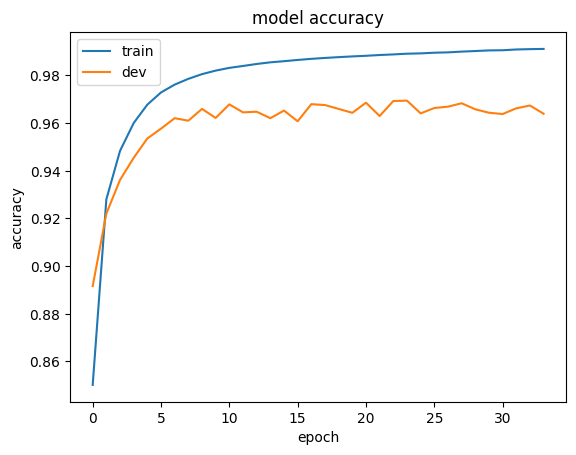

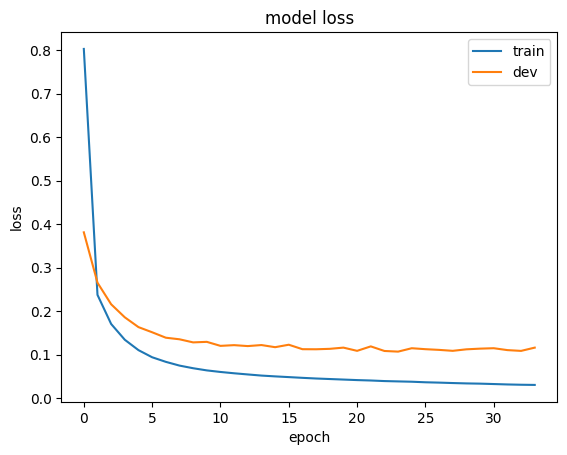

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

**Model Evaluation**

In [ ]:
def evaluate_model(X, y, model, set_name):
    import numpy as np
    from sklearn.metrics import classification_report, precision_recall_curve, auc

    # Predict using the model
    y_pred_1 = model.predict(X)
    y_pred = np.argmax(y_pred_1, axis=-1)
    y_true = np.argmax(y, axis=-1)

    # Exclude class 0 from labels and predictions
    valid_indices = y_true != 0
    valid_labels = y_true[valid_indices]
    valid_predictions = y_pred[valid_indices]

    print(f"\n\n-----------Prediction Scores for {set_name}-----------\n")

    # Create a classification report, specifying labels to exclude class 0
    labels = list(range(1, 16))
    target_names = [modified_dict_1[i] for i in labels]
    report = classification_report(valid_labels, valid_predictions, labels=labels, target_names=target_names)
    print(report)

    # Calculate precision-recall curves and AUC for each class
    precision = dict()
    recall = dict()
    pr_auc = dict()

    for i in labels:
        y_true_binary = (y_true == i).astype(int).flatten()
        y_pred_binary = (y_pred == i).astype(int).flatten()
        precision[i], recall[i], _ = precision_recall_curve(y_true_binary, y_pred_binary)
        pr_auc[i] = auc(recall[i], precision[i])

    # Print calculated scores for each class
    for i in labels:
        print(f"Class {modified_dict_1[i]} - AUC-PR: {pr_auc[i]}")

    # Calculate macro AUC-PR
    all_recall = np.unique(np.concatenate([recall[i] for i in labels]))
    mean_precision = np.zeros_like(all_recall)
    for i in labels:
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= len(labels)
    macro_pr_auc = auc(all_recall, mean_precision)

    # Print macro AUC-PR
    print(f"Macro AUC-PR: {macro_pr_auc}\n\n")
    return macro_pr_auc

# Evaluate the model on training, testing, and dev sets
train_eval = evaluate_model(X_train_padded, y_train, bidirect_model, "Train Set")
test_eval = evaluate_model(X_test_padded, y_test, bidirect_model, "Test Set")
dev_eval = evaluate_model(X_dev_padded, y_dev, bidirect_model, "Dev Set")

# Print evaluation results
print("Training dataset evaluation: \n", train_eval, "\n\n")
print("Test dataset evaluation: \n", test_eval, "\n\n")
print("Development dataset evaluation: \n", dev_eval, "\n\n")

123/123 [==============================] - 9s 76ms/step


-----------Prediction Scores for Train Set-----------

              precision    recall  f1-score   support

        NOUN       0.96      0.98      0.97     21484
         ADP       1.00      1.00      1.00     16796
         DET       0.99      1.00      0.99     16486
       PUNCT       1.00      1.00      1.00     12259
        VERB       0.95      0.96      0.96      8140
         ADJ       0.92      0.93      0.93      7432
       PROPN       0.95      0.85      0.90      4470
         ADV       0.94      0.94      0.94      4127
         AUX       0.99      0.98      0.98      3584
        PRON       0.96      0.93      0.95      3557
         NUM       0.98      0.94      0.96      2862
       CCONJ       0.98      0.95      0.96      2806
       SCONJ       0.86      0.88      0.87       808
           X       0.87      0.77      0.82       142
        INTJ       0.80      0.62      0.70        26

   micro avg       0.